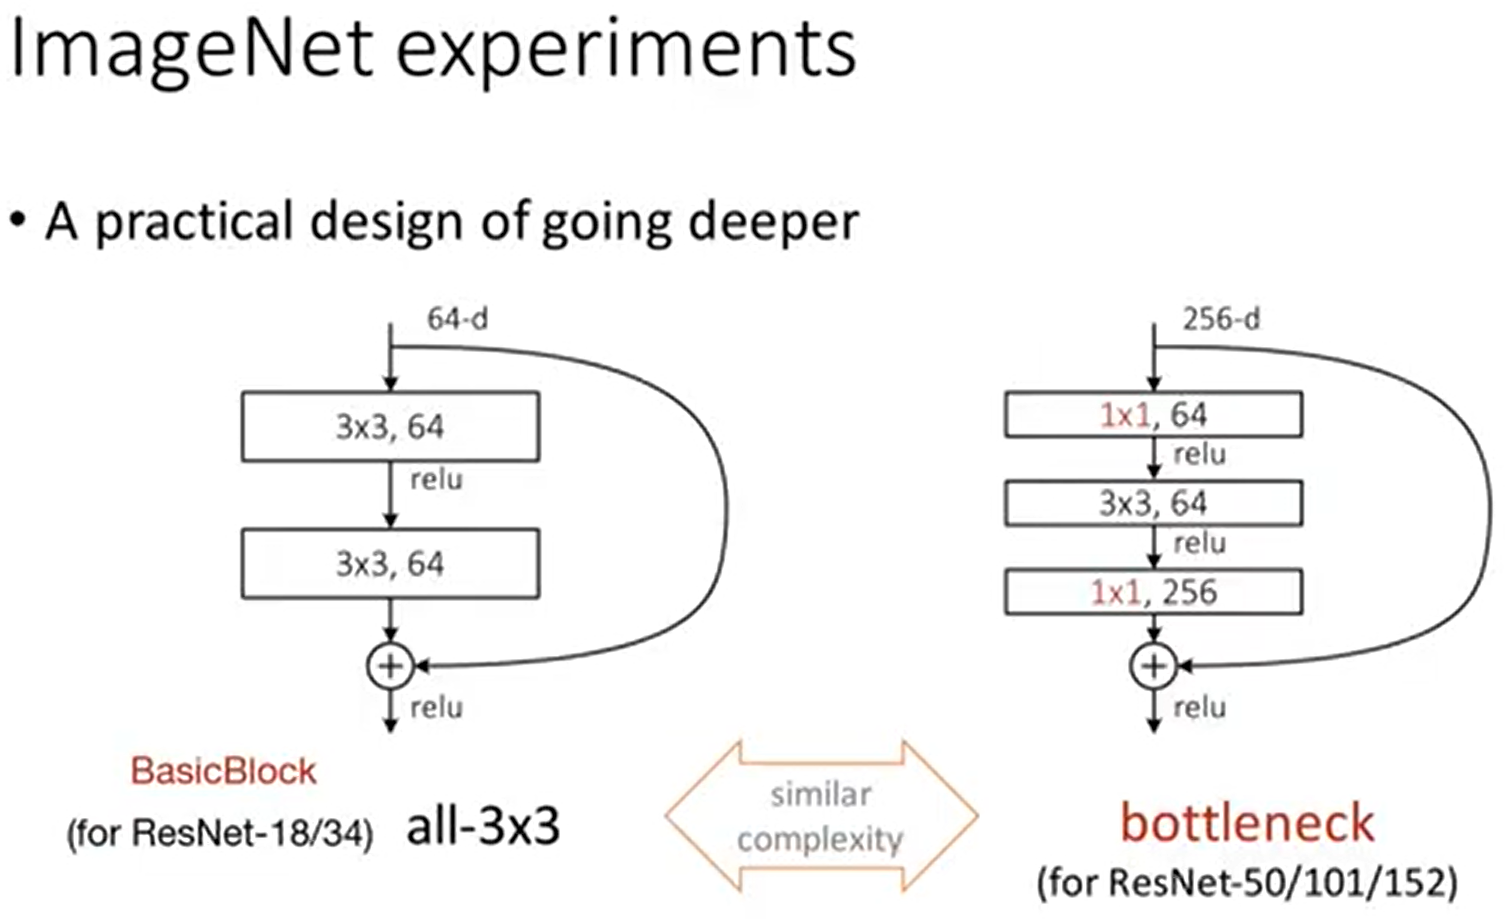

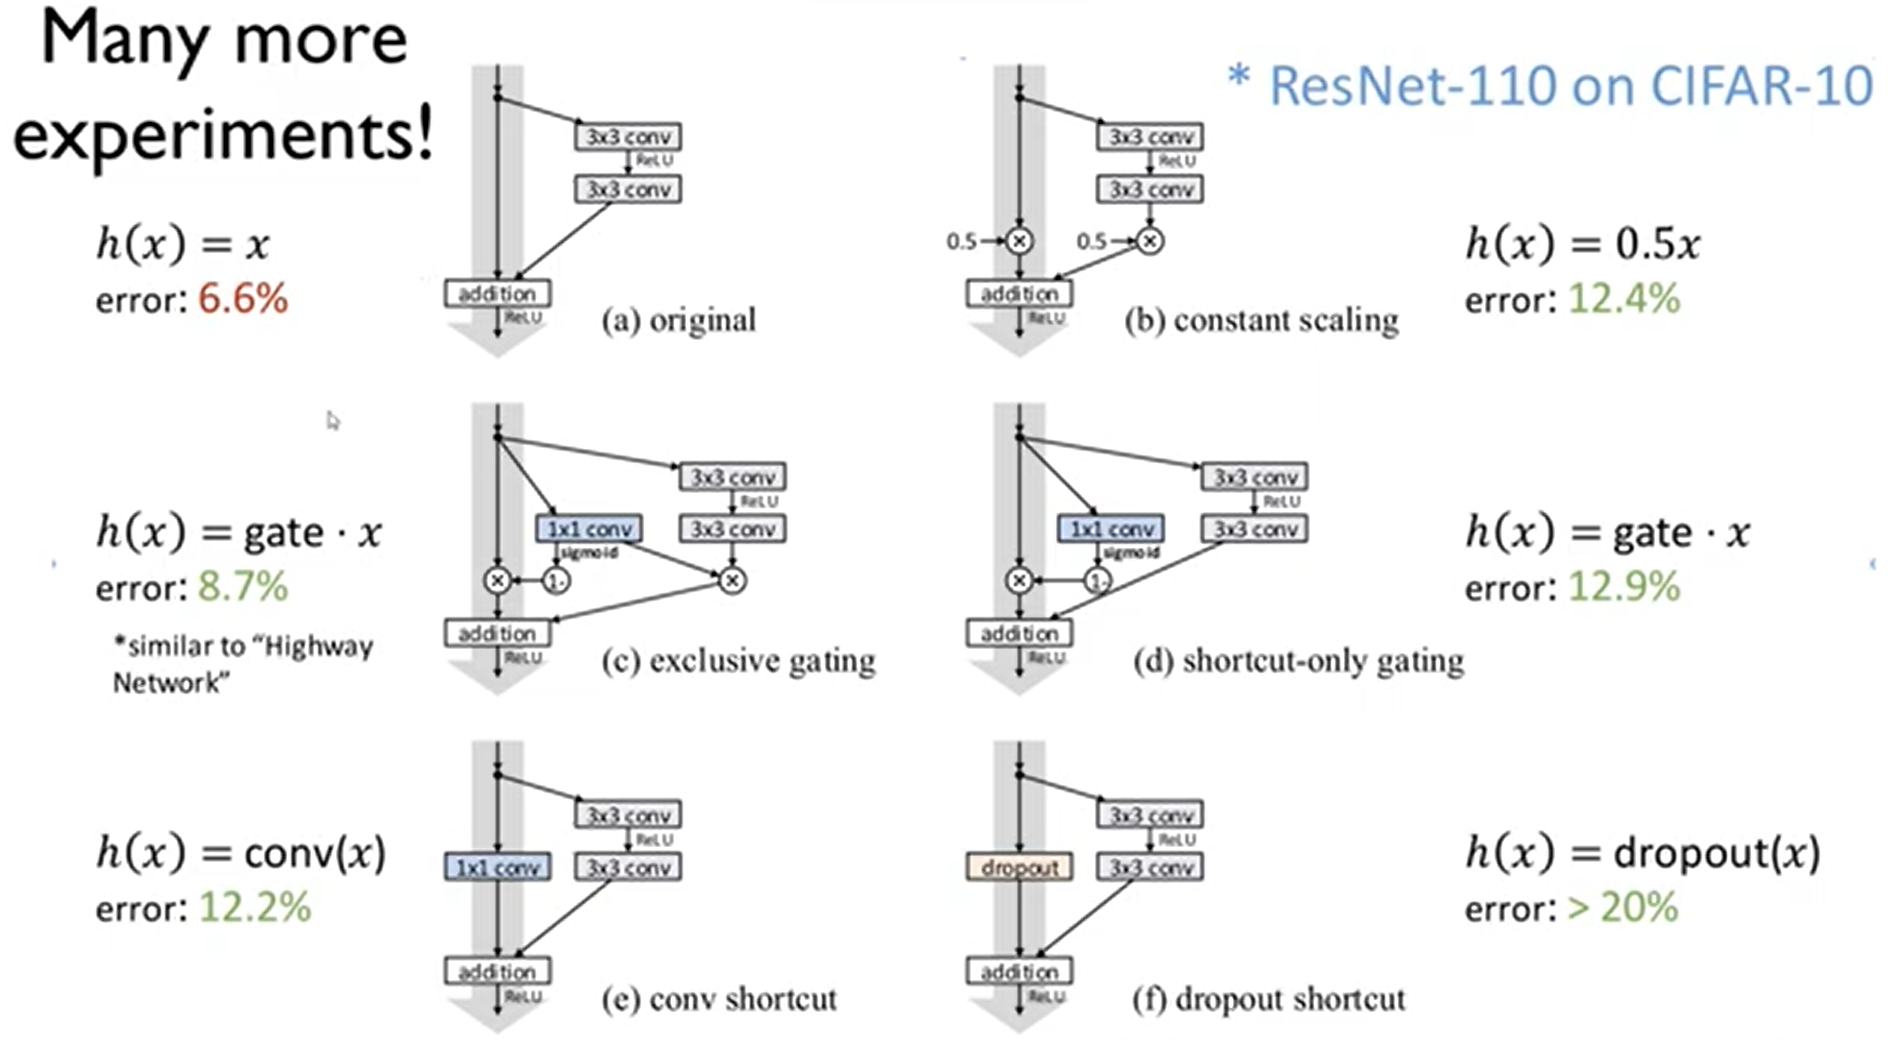

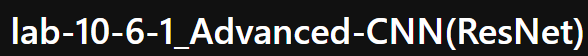

In [18]:
import torch.nn as nn
import torch.utils.model_zoo as model_zoo

__all__ = ['ResNet', 'resnet18', 'resnet34', 'resnet50', 'resnet101',
           'resnet152']


model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}

In [19]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


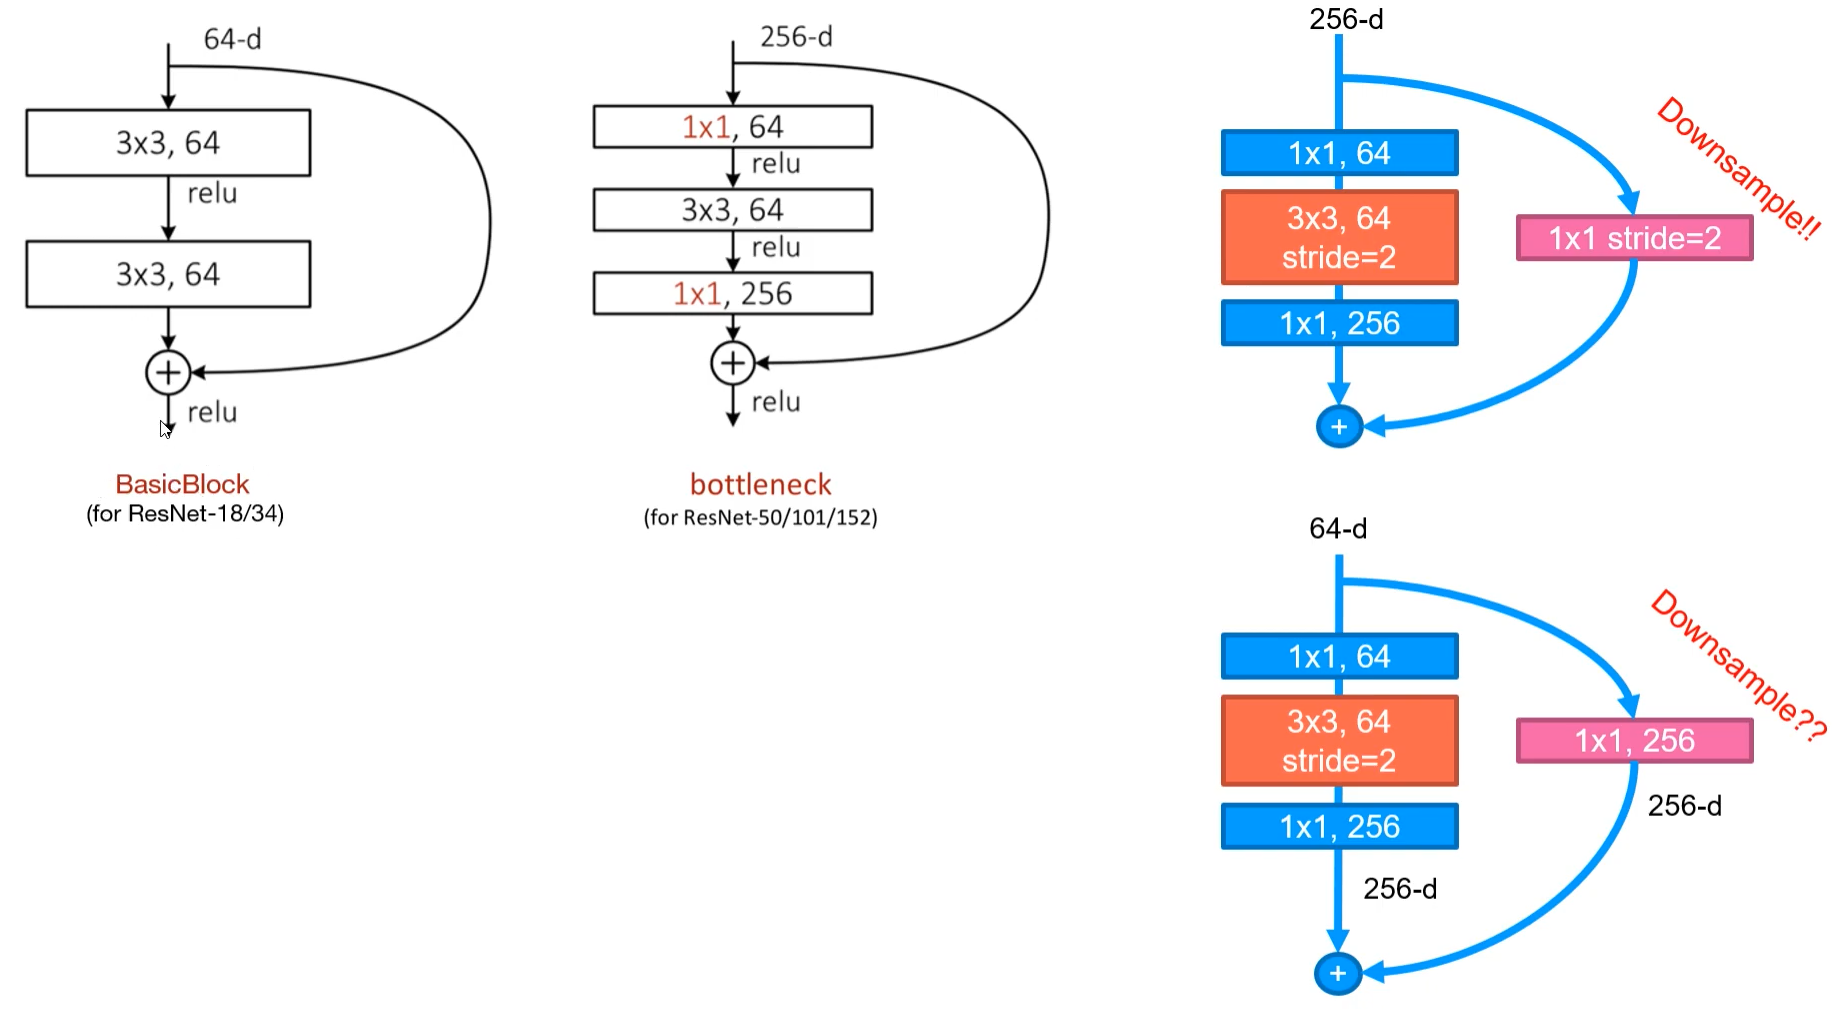

In [20]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        #x.shape = 3x64x64
        identity = x
        #identity = 3x64x64
        out = self.conv1(x)     #3x3 stride = 2
        #out.shape = 3x32x32
        out = self.bn1(out)
        out = self.relu(out)
        #out.shape = 3x32x32
        out = self.conv2(out)   #3x3 stride = 1
        #out.shape = 3x32x32
        out = self.bn2(out)
        #out.shape = 3x32x32


        if self. downsample is not None:
            identity = self.downsample(x)

        #만약 downsample이 없다면 out.shape = 3x32x32, identity = 3x64x64 여서 덧셈이 불가

        out += identity
        out = self.relu(out)

        return out

In [21]:
class Bottleneck(nn.Module):
    expasion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes) #conv1x1(64,64)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride)#conv3x3(64,64)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion) #conv1x1(64,256)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x) # 1x1 stride = 1
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out) # 3x3 stride = stride 
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out) # 1x1 stride = 1
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [22]:
class ResNet(nn.Module):
    #model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs) #resnet 50
    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNet, self).__init__()

        self.inplanes = 64

        #inputs = 3x224x224
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        #outputs = self.conv1(inputs)
        #outputs.shape = [64x112x112]

        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        
        #inputs = [64x112x112]
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        #output = [64x56x56]

        self.layer1 = self._make_layer(block, 64, layers[0],'''3''')
        self.layer2 = self._make_layer(block, 128, layers[1],'''4''', stride=2)
        self.layer3 = self._make_layer(block, 256, layers[1],'''6''', stride=2)
        self.layer4 = self._make_layer(block, 512, layers[1],'''3''', stride=2)


        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)
    
    #self.inplanes = 64
    #self.layer1 = self._make_layer(Bottleneck, 64, 3)
    def _make_layer(self, block, planes, blocks, stride=1):
        
        downsample = None
        
        if stride != 1 or self.inplanes != planes * block.expansion:    #64 != 256
            
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride), #conv1x1(64, 256, 1)
                nn.BatchNorm2d(planes * block.expansion), #batchnrom2d(256)
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        #layers.append(Bottleneck(64, 64, 1, downsample))

        self.inplanes = planes * block.expansion #self.inplanes = 128 * 4
        
        for _ in range(1, blocks): 
        #for _ in range(1, 3):
            layers.append(block(self.inplanes, planes)) # * 2

        return nn.Sequential(*layers)
    
    #self.layer1 = [
    #   Bottleneck(64, 64, 1, downsample)
    #   Bottleneck(256, 64)
    #   Bottleneck(256, 64)
    # ]


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [23]:
def resnet18(pretranined=False, **kwargs):
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)  #=> 2*(2+2+2+2) +1(conv1) +1(fc)  = 16 +2 =resnet 18  #[] => 데이터가 통과하는 convolution layer 개수
    return model

In [24]:
def resnet50(pretrained=False, **kwargs):
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs) #=> 3*(3+4+6+3) +(conv1) +1(fc) = 48 +2 = 50
    return model

In [25]:
def resnet152(pretrained=False, **kwargs):
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs) # 3*(3+8+36+3) +2 = 150+2 = resnet152    
    return model

In [26]:
import torchvision.models.resnet as resnet          #정확한 위치

In [27]:
res = resnet.resnet50()

In [28]:
res

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 